# DARE Deluxe Data Challenge
DARE 2023

In this notebook, we will provide a template for the DARE Deluxe Data Challenge. The main steps covered here will be:

- Load the data
- Provide an overview of what is in the data
- Provide an example of a terribly performing baseline model
- Provide functions to quantify model predictive performance


TODO:
- GET DEM elevation at each gauge

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


## Imports and settings
Everything we need to get started.

In [2]:
import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# import functions
from functions.preprocessing import (
    load_environode, convert_environode_daily, daily_averaging,
    load_llara_gauges, load_silo_gauges
)

## 1 Load the data
Briefly look at the contents and structure of the data.

In [3]:
date_start = '2022-01-01' #based on initial plotting
date_end = '2023-03-31' #based on initial plotting

## 1.1 Soil Moisture Data

In [4]:
data_dir = os.path.join('.','data','raw_data')
filestub = 'Download'
rm_gauges = ['WE 16-07 B0', 'WW 12-03 93']

sm_comb = load_environode(data_dir,filestub,utc_to_aest=True)
# get rid of the sticky-outy bit
sm_comb.drop(columns=['v1'],inplace=True)
# drop duplicate gauges
sm_comb = sm_comb.loc[~sm_comb['device'].isin(rm_gauges),:]
# sm_comb.head()

daily_sm_data = convert_environode_daily(sm_comb,type='9am-mean')
# Data cleaning as per Willem's code
vcols = [c for c in sm_comb.columns if c.startswith('v')]
for this_v in vcols:
    daily_sm_data.loc[daily_sm_data[this_v]<0,this_v] = np.nan
    daily_sm_data.loc[daily_sm_data[this_v]>125,this_v] = np.nan

# keep v2 - v6
daily_sm_data = daily_sm_data.loc[:,['Date','device','v2','v3','v4']]

display(daily_sm_data.head())
display(daily_sm_data.tail())

./data/raw_data/Download2022-04-17_2021-10-19.csv
./data/raw_data/Download2023-04-12_2022-10-14.csv
./data/raw_data/Download2022-10-14_2022-04-17.csv
Summarising daily data per device - 32 gauges
Gauge: WE 12-06 A6 start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-01 A0 start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-02 A2 start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WW 12-04 AC start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 16-05 B5 start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 16-03 B3 start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WW 16-03 9C start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-04 A4 start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 12-05 A5 start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WW 12-02 AB start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WE 16-01 B1 start: 2021-10-19 00:00:00 end: 2023-04-12 00:00:00
Gauge: WW 16-02 A9 star

,Date,device,v2,v3,v4
0,2021-10-19,WE 12-06 A6,NaN,NaN,NaN
1,2021-10-20,WE 12-06 A6,NaN,NaN,NaN
2,2021-10-21,WE 12-06 A6,NaN,NaN,NaN
3,2021-10-22,WE 12-06 A6,NaN,NaN,NaN
4,2021-10-23,WE 12-06 A6,NaN,NaN,NaN


,Date,device,v2,v3,v4
17307,2023-04-08,WW 12-03 AE,18.275556,15.736528,14.513750
17308,2023-04-09,WW 12-03 AE,17.956944,16.401528,15.612500
17309,2023-04-10,WW 12-03 AE,17.471111,16.199167,15.757083
17310,2023-04-11,WW 12-03 AE,17.065694,15.922361,15.637639
17311,2023-04-12,WW 12-03 AE,16.726429,15.679000,15.478571


<Axes: xlabel='Date'>

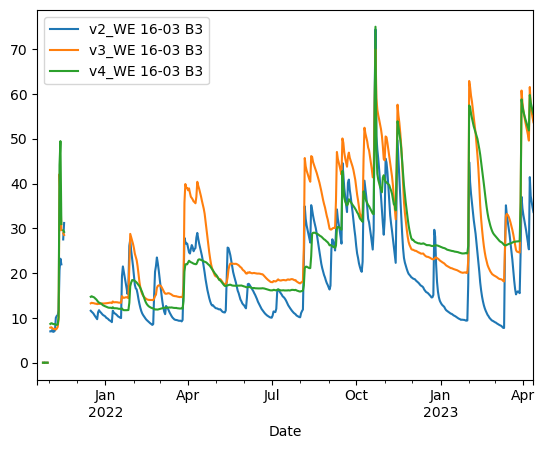

In [5]:
# restrict to a number of devices
device_keep = ['WE 16-03 B3']
daily_smss_data = daily_sm_data.query('device == @device_keep').copy()
daily_smss_data = daily_smss_data.pivot(index='Date',columns='device',values=['v2','v3','v4'])
daily_smss_data.columns = ['_'.join(col).strip() for col in daily_smss_data.columns.values]
daily_smss_data.plot()

## 1.2 Rainfall Data


In [6]:
# now get from other llara rain gauges
llara_gauges = {
    'mulgate': 'Llara_Mulgate_Creek-19900101-MF6IW2.csv',
    # 'south': 'Llara_South-19900101-bNI22T.csv',
    'wheat': 'Wheat_Research_Narrabri-19900101-VRyvYZ.csv'
}
col_convert = {
    'Time': 'Date',
    ' Rain Since 9am (mm)': 'rain',
    ' Temperature (C)': 'temp',
    ' Rel Humidity (%)': 'relhumidity',
    ' Solar Rad (kWh/m^2)': 'solarrad',
    ' Wind (km/h)': 'windspeed',
    ' Wind Dir': 'winddir',
    ' MSLP (hPa)': 'mlsp',
    ' UV': 'uv'
}

llara_data = load_llara_gauges(data_dir,llara_gauges,col_convert)
# drop if a gauge is missing that varibale entirely
llara_data = llara_data.dropna(axis=1,how='all')

display(llara_data.head())
display(llara_data.tail())

Llara_Mulgate_Creek-19900101-MF6IW2.csv
Wheat_Research_Narrabri-19900101-VRyvYZ.csv


,rain_mulgate,temp_mulgate,windspeed_mulgate,winddir_mulgate,relhumidity_mulgate,solarrad_mulgate,rain_wheat,temp_wheat,windspeed_wheat,winddir_wheat,mlsp_wheat,relhumidity_wheat,solarrad_wheat,uv_wheat
Time,,,,,,,,,,,,,,
2013-04-21,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.194444,12.525556,146.577778,1012.887778,66.177778,2.104444,1.067778
2013-04-22,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18.827368,5.337895,192.631579,1010.740000,47.031579,2.269474,1.316842
2013-04-23,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.175532,7.289362,168.202128,1011.070213,48.085106,2.317021,1.198936
2013-04-24,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.612632,6.190526,149.178947,1015.072632,51.652632,2.252632,1.190526
2013-04-25,NaN,NaN,NaN,NaN,NaN,NaN,0.0,14.603158,6.296842,163.831579,1018.136842,53.863158,2.254737,1.188421


,rain_mulgate,temp_mulgate,windspeed_mulgate,winddir_mulgate,relhumidity_mulgate,solarrad_mulgate,rain_wheat,temp_wheat,windspeed_wheat,winddir_wheat,mlsp_wheat,relhumidity_wheat,solarrad_wheat,uv_wheat
Time,,,,,,,,,,,,,,
2023-04-24,0.0,19.016667,16.167708,163.666667,64.510417,1.925313,0.0,19.085417,18.315625,148.979167,1028.102292,64.218750,2.076771,1.012500
2023-04-25,0.0,19.448958,10.304167,146.906250,63.645833,1.844583,0.0,19.044211,11.480000,130.736842,1027.595263,64.673684,1.856842,0.917895
2023-04-26,0.0,17.230208,8.130208,146.270833,63.291667,1.965625,0.0,16.652688,7.815054,137.537634,1025.015161,64.774194,2.013226,0.910753
2023-04-27,0.0,18.927083,8.763542,149.572917,58.156250,1.972188,0.0,17.889011,4.819780,126.384615,1023.540330,61.461538,1.944725,0.892308
2023-04-28,0.0,22.795652,5.860870,207.304348,51.869565,1.810435,0.0,22.831818,4.786364,190.954545,1022.351818,51.272727,1.663636,2.618182


## 1.3 SILO Data


In [7]:
# We will also load the silo data for the same period

# now get from other llara rain gauges
silo_gauges = {
    'narrabri': '53026.txt',
    'turrawan': '55058.txt',
}
col_convert = {
    'Date': 'Date',
    'Rain': 'rain',
    'T.Max': 'tempmax',
    'T.Min': 'tempmin',
    'Evap': 'evap',
}

silo_data = load_silo_gauges(data_dir,silo_gauges,col_convert)

# evap needs to be moved forward a day to overlap the same period
# thanks to SILOs interpretation
for _ in silo_data.columns:
    if 'evap' in _:
        silo_data[_] = silo_data[_].shift(1)


display(silo_data.head())
display(silo_data.tail())

,tempmax_narrabri,tempmin_narrabri,rain_narrabri,evap_narrabri,tempmax_turrawan,tempmin_turrawan,rain_turrawan,evap_turrawan
Date,,,,,,,,
2021-10-19,28.8,9.8,0.0,NaN,28.3,8.8,0.0,NaN
2021-10-20,26.5,11.0,0.0,5.4,25.9,10.5,0.0,5.2
2021-10-21,26.4,10.1,0.0,5.3,26.3,9.9,0.0,5.1
2021-10-22,30.0,10.5,0.0,4.9,29.6,10.6,0.0,4.7
2021-10-23,35.3,13.5,0.0,6.0,34.6,12.6,0.0,5.8


,tempmax_narrabri,tempmin_narrabri,rain_narrabri,evap_narrabri,tempmax_turrawan,tempmin_turrawan,rain_turrawan,evap_turrawan
Date,,,,,,,,
2023-04-22,26.0,10.3,0.0,3.2,25.5,10.5,0.0,3.0
2023-04-23,26.0,10.7,0.0,2.9,25.6,10.9,0.0,2.7
2023-04-24,26.6,11.6,0.0,3.1,26.3,11.2,0.0,2.9
2023-04-25,26.4,12.7,0.0,3.0,25.9,11.8,0.0,2.9
2023-04-26,25.4,7.7,0.0,3.5,25.2,6.7,0.0,3.4


## 1.4 Meta Data


,site,loc,treatment,treatment rep,longitude,latitude,geometry
0,WW,WW_12_01,Treatment,T1,149.842307,-30.262072,POINT (149.84231 -30.26207)
1,WW,WW_12_01,Treatment,T1,149.842307,-30.262072,POINT (149.84231 -30.26207)
2,WW,WW_16_01,Treatment,T2,149.844457,-30.263997,POINT (149.84446 -30.26400)
3,WW,WW_16_01,Treatment,T2,149.844457,-30.263997,POINT (149.84446 -30.26400)
4,WW,WW_12_02,Treatment,T3,149.846010,-30.260622,POINT (149.84601 -30.26062)


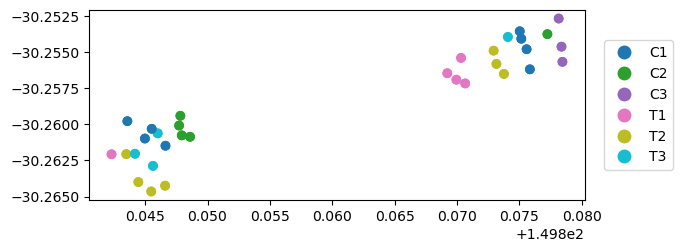

In [8]:
sm_meta = pd.read_csv(os.path.join(data_dir,'sm_gauge_metadata.csv'))
# convert loc_meta into a geopandas dataframe
sm_meta = gpd.GeoDataFrame(
    sm_meta, geometry=gpd.points_from_xy(sm_meta.longitude, sm_meta.latitude)
)
sm_meta.loc[:,'loc'] = sm_meta.loc[:,'loc'].str.strip()
# and transform to EPSG 23855
sm_meta = sm_meta.set_crs('EPSG:4326')
# sm_meta = sm_meta.to_crs('EPSG:28355')

cmap = sns.color_palette("Set2", as_cmap=True)

ax = sm_meta.plot(column='treatment rep',legend=True)#color=loc_meta['treatment'].astype('category').cat.codes.map(cmap))
ax.get_legend()._set_loc(6)
ax.get_legend().set_bbox_to_anchor((1.025, 0.5))

sm_meta.head()

## 2 Dataset description


In [9]:
# lets look at some properties of the data
print('#'*80) 
print('Soil Moisture Summary') 
print('Number of gauges: {}'.format(daily_smss_data.columns.shape[0]))
print('Number of observations: {}'.format(daily_smss_data.shape[0]))
for this_gauge in daily_smss_data.columns:
    print('Number of NaNs: {} for {}'.format(daily_smss_data[this_gauge].isna().sum(),this_gauge))

display(daily_smss_data.describe())

print('#'*80) 
print('Llara Rain Summary') 
print('Number of gauges: {}'.format(llara_data.columns.shape[0]))
print('Number of observations: {}'.format(llara_data.shape[0]))
for this_gauge in llara_data.columns:
    print('Number of NaNs: {} for {}'.format(llara_data[this_gauge].isna().sum(),this_gauge))

display(llara_data.describe())

print('#'*80) 
print('SILO Summary') 
print('Number of gauges: {}'.format(silo_data.columns.shape[0]))
print('Number of observations: {}'.format(silo_data.shape[0]))
for this_gauge in silo_data.columns:
    print('Number of NaNs: {} for {}'.format(silo_data[this_gauge].isna().sum(),this_gauge))

display(silo_data.describe())

################################################################################
Soil Moisture Summary
Number of gauges: 3
Number of observations: 541
Number of NaNs: 36 for v2_WE 16-03 B3
Number of NaNs: 36 for v3_WE 16-03 B3
Number of NaNs: 36 for v4_WE 16-03 B3


,v2_WE 16-03 B3,v3_WE 16-03 B3,v4_WE 16-03 B3
count,505.000000,505.000000,505.000000
mean,19.156274,27.113675,24.504414
std,10.199545,13.343094,11.948330
min,0.000000,0.000000,0.000000
25%,11.149855,18.168310,16.171944
50%,16.081667,22.099444,22.871389
75%,25.715915,36.775972,29.038750
max,74.428732,69.934648,75.030563


################################################################################
Llara Rain Summary
Number of gauges: 14
Number of observations: 3660
Number of NaNs: 1529 for rain_mulgate
Number of NaNs: 1525 for temp_mulgate
Number of NaNs: 1525 for windspeed_mulgate
Number of NaNs: 1525 for winddir_mulgate
Number of NaNs: 1525 for relhumidity_mulgate
Number of NaNs: 1533 for solarrad_mulgate
Number of NaNs: 37 for rain_wheat
Number of NaNs: 38 for temp_wheat
Number of NaNs: 38 for windspeed_wheat
Number of NaNs: 38 for winddir_wheat
Number of NaNs: 38 for mlsp_wheat
Number of NaNs: 38 for relhumidity_wheat
Number of NaNs: 38 for solarrad_wheat
Number of NaNs: 38 for uv_wheat


,rain_mulgate,temp_mulgate,windspeed_mulgate,winddir_mulgate,relhumidity_mulgate,solarrad_mulgate,rain_wheat,temp_wheat,windspeed_wheat,winddir_wheat,mlsp_wheat,relhumidity_wheat,solarrad_wheat,uv_wheat
count,2131.000000,2135.000000,2135.000000,2135.000000,2135.000000,2127.000000,3623.000000,3622.000000,3622.000000,3622.000000,3622.000000,3622.000000,3622.000000,3622.000000
mean,1.478555,18.863571,7.969224,170.410493,60.106692,2.168404,1.646426,18.962750,8.827618,153.804994,1015.493298,61.414343,2.121858,1.375716
std,5.492534,6.814114,4.366226,36.956049,16.222350,0.824603,5.985535,6.918944,4.490002,44.878917,5.682024,16.365681,0.815537,0.827105
min,0.000000,5.053125,0.000000,26.895833,13.062500,0.000000,0.000000,4.133333,0.000000,0.000000,997.118085,17.336735,0.046842,0.000000
25%,0.000000,13.259375,4.904687,148.723958,48.145833,1.590729,0.000000,13.155585,5.498703,126.107298,1011.342092,48.578219,1.501576,0.641655
50%,0.000000,19.071875,7.215625,171.041667,61.260417,2.180625,0.000000,19.206848,7.970512,147.827193,1015.579062,62.470885,2.133593,1.223558
75%,0.000000,24.100000,10.032467,189.348958,72.416667,2.825417,0.000000,24.590886,11.409159,177.328125,1019.689877,74.394701,2.803869,2.052117
max,81.600000,35.393750,26.316667,329.583333,95.020833,4.166567,77.280000,37.026596,29.169388,335.343750,1032.082796,96.184783,5.250000,8.235294


################################################################################
SILO Summary
Number of gauges: 8
Number of observations: 555
Number of NaNs: 0 for tempmax_narrabri
Number of NaNs: 0 for tempmin_narrabri
Number of NaNs: 0 for rain_narrabri
Number of NaNs: 1 for evap_narrabri
Number of NaNs: 0 for tempmax_turrawan
Number of NaNs: 0 for tempmin_turrawan
Number of NaNs: 0 for rain_turrawan
Number of NaNs: 1 for evap_turrawan


,tempmax_narrabri,tempmin_narrabri,rain_narrabri,evap_narrabri,tempmax_turrawan,tempmin_turrawan,rain_turrawan,evap_turrawan
count,555.000000,555.000000,555.000000,554.000000,555.000000,555.000000,555.000000,554.000000
mean,27.315856,13.002162,2.467207,4.672563,27.028468,12.449369,1.902883,4.552527
std,6.300768,5.891200,8.162877,2.142510,6.192086,5.898618,5.414680,2.106591
min,12.500000,-1.900000,0.000000,0.600000,12.200000,-2.700000,0.000000,0.500000
25%,22.150000,9.100000,0.000000,2.800000,22.000000,8.650000,0.000000,2.800000
50%,27.800000,14.200000,0.000000,4.500000,27.300000,13.400000,0.000000,4.350000
75%,32.500000,17.700000,0.000000,6.500000,32.000000,17.150000,0.000000,6.400000
max,40.300000,24.600000,76.000000,9.700000,40.000000,23.400000,35.000000,9.500000


# 3 Combine the data

## 3.1 Lag the variables

In [10]:
# lag the variables - silo
silo_data_l1 = silo_data.shift(1)
silo_data_l1.columns = [this_col+'_lag1' for this_col in silo_data_l1.columns]
silo_data_l2 = silo_data.shift(2)
silo_data_l2.columns = [this_col+'_lag2' for this_col in silo_data_l2.columns]
silo_data_l3 = silo_data.shift(3)
silo_data_l3.columns = [this_col+'_lag3' for this_col in silo_data_l3.columns]

# combine the data
silo_data_lag = pd.concat([silo_data,silo_data_l1,silo_data_l2,silo_data_l3],axis=1)
silo_data_lag

# lag the variables - llara
llara_data_l1 = llara_data.shift(1)
llara_data_l1.columns = [this_col+'_lag1' for this_col in llara_data_l1.columns]
llara_data_l2 = llara_data.shift(2)
llara_data_l2.columns = [this_col+'_lag2' for this_col in llara_data_l2.columns]
llara_data_l3 = llara_data.shift(3)
llara_data_l3.columns = [this_col+'_lag3' for this_col in llara_data_l3.columns]

# combine the data
llara_data_lag = pd.concat([llara_data,llara_data_l1,llara_data_l2,llara_data_l3],axis=1)
llara_data_lag

# lag the soil moisture data
daily_smss_data_l1 = daily_smss_data.shift(1)
daily_smss_data_l1.columns = [this_col+'_lag1' for this_col in daily_smss_data_l1.columns]

# combine the data
daily_smss_data_lag = pd.concat([daily_smss_data,daily_smss_data_l1],axis=1)
daily_smss_data_lag

,v2_WE 16-03 B3,v3_WE 16-03 B3,v4_WE 16-03 B3,v2_WE 16-03 B3_lag1,v3_WE 16-03 B3_lag1,v4_WE 16-03 B3_lag1
Date,,,,,,
2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-20,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-21,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-22,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-23,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-04-08,41.444722,61.561944,59.785278,25.325000,49.600556,51.865000
2023-04-09,37.192500,57.718611,58.097778,41.444722,61.561944,59.785278
2023-04-10,35.861806,56.044861,57.131389,37.192500,57.718611,58.097778


## 3.2 Combine forcing into one dataframe

In [11]:
# remove dates before the start date
silo_data_lag = silo_data_lag[date_start:date_end]
llara_data_lag = llara_data_lag[date_start:date_end]
daily_smss_data_lag = daily_smss_data_lag.loc[date_start:date_end]

# combine all of our daily dataframes into one
daily_data = pd.concat([silo_data_lag,llara_data_lag],axis=1,sort=True)
daily_data.sort_index(inplace=True)
daily_data.sort_index(axis=1,inplace=True)
# constrain to the soil moisture data period
daily_data = daily_data.loc[daily_smss_data_lag.index.min().strftime('%Y-%m-%d'):daily_smss_data_lag.index.max().strftime('%Y-%m-%d'),:]
# drop any all nan columns
daily_data.dropna(axis=1,how='all',inplace=True)
daily_data

,evap_narrabri,evap_narrabri_lag1,evap_narrabri_lag2,evap_narrabri_lag3,evap_turrawan,evap_turrawan_lag1,evap_turrawan_lag2,evap_turrawan_lag3,mlsp_wheat,mlsp_wheat_lag1,...,winddir_wheat_lag2,winddir_wheat_lag3,windspeed_mulgate,windspeed_mulgate_lag1,windspeed_mulgate_lag2,windspeed_mulgate_lag3,windspeed_wheat,windspeed_wheat_lag1,windspeed_wheat_lag2,windspeed_wheat_lag3
2022-01-01,6.5,6.8,6.4,4.7,6.5,6.7,6.1,4.5,1011.947474,1013.230645,...,135.410526,140.273684,8.784375,7.819792,10.697917,14.258333,9.548421,7.380645,9.246316,14.586316
2022-01-02,5.9,6.5,6.8,6.4,5.7,6.5,6.7,6.1,1011.008298,1011.947474,...,130.580645,135.410526,5.294792,8.784375,7.819792,10.697917,5.592553,9.548421,7.380645,9.246316
2022-01-03,7.7,5.9,6.5,6.8,7.5,5.7,6.5,6.7,1007.383441,1011.008298,...,112.052632,130.580645,7.663542,5.294792,8.784375,7.819792,7.572043,5.592553,9.548421,7.380645
2022-01-04,7.5,7.7,5.9,6.5,7.3,7.5,5.7,6.5,1006.500412,1007.383441,...,160.446809,112.052632,18.892708,7.663542,5.294792,8.784375,18.122680,7.572043,5.592553,9.548421
2022-01-05,8.3,7.5,7.7,5.9,7.9,7.3,7.5,5.7,1006.508660,1006.500412,...,149.537634,160.446809,20.490625,18.892708,7.663542,5.294792,20.786598,18.122680,7.572043,5.592553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,3.9,4.4,3.8,5.0,3.8,4.1,3.7,4.8,1013.257872,1014.186421,...,190.117021,219.978495,6.966667,11.014583,10.233333,11.113542,8.250000,13.588421,11.538298,12.730108
2023-03-28,3.3,3.9,4.4,3.8,3.2,3.8,4.1,3.7,1013.392000,1013.257872,...,127.252632,190.117021,9.188542,6.966667,11.014583,10.233333,11.463158,8.250000,13.588421,11.538298
2023-03-29,3.7,3.3,3.9,4.4,3.6,3.2,3.8,4.1,1012.011856,1013.392000,...,92.531915,127.252632,10.473958,9.188542,6.966667,11.014583,10.927835,11.463158,8.250000,13.588421
2023-03-30,3.5,3.7,3.3,3.9,3.4,3.6,3.2,3.8,1008.559691,1012.011856,...,137.157895,92.531915,9.015625,10.473958,9.188542,6.966667,10.381443,10.927835,11.463158,8.250000


## 3.3 Summarise to check no missing data

In [12]:
# lets look at some properties of the data
print('#'*80) 
print('Daily Data Summary') 
print('Number of gauges: {}'.format(daily_data.columns.shape[0]))
print('Number of observations: {}'.format(daily_data.shape[0]))
for this_gauge in daily_data.columns:
    print('Number of NaNs: {} for {}'.format(daily_data[this_gauge].isna().sum(),this_gauge))

display(daily_data.describe())

print('#'*80)
print('Soil Moisture Summary')
print('Number of gauges: {}'.format(daily_smss_data_lag.columns.shape[0]))
print('Number of observations: {}'.format(daily_smss_data_lag.shape[0]))
for this_gauge in daily_smss_data_lag.columns:
    print('Number of NaNs: {} for {}'.format(daily_smss_data_lag[this_gauge].isna().sum(),this_gauge))

display(daily_smss_data_lag.describe())

################################################################################
Daily Data Summary
Number of gauges: 88
Number of observations: 455
Number of NaNs: 0 for evap_narrabri
Number of NaNs: 0 for evap_narrabri_lag1
Number of NaNs: 0 for evap_narrabri_lag2
Number of NaNs: 0 for evap_narrabri_lag3
Number of NaNs: 0 for evap_turrawan
Number of NaNs: 0 for evap_turrawan_lag1
Number of NaNs: 0 for evap_turrawan_lag2
Number of NaNs: 0 for evap_turrawan_lag3
Number of NaNs: 0 for mlsp_wheat
Number of NaNs: 0 for mlsp_wheat_lag1
Number of NaNs: 0 for mlsp_wheat_lag2
Number of NaNs: 0 for mlsp_wheat_lag3
Number of NaNs: 0 for rain_mulgate
Number of NaNs: 0 for rain_mulgate_lag1
Number of NaNs: 0 for rain_mulgate_lag2
Number of NaNs: 0 for rain_mulgate_lag3
Number of NaNs: 0 for rain_narrabri
Number of NaNs: 0 for rain_narrabri_lag1
Number of NaNs: 0 for rain_narrabri_lag2
Number of NaNs: 0 for rain_narrabri_lag3
Number of NaNs: 0 for rain_turrawan
Number of NaNs: 0 for rain_turrawan_

,evap_narrabri,evap_narrabri_lag1,evap_narrabri_lag2,evap_narrabri_lag3,evap_turrawan,evap_turrawan_lag1,evap_turrawan_lag2,evap_turrawan_lag3,mlsp_wheat,mlsp_wheat_lag1,...,winddir_wheat_lag2,winddir_wheat_lag3,windspeed_mulgate,windspeed_mulgate_lag1,windspeed_mulgate_lag2,windspeed_mulgate_lag3,windspeed_wheat,windspeed_wheat_lag1,windspeed_wheat_lag2,windspeed_wheat_lag3
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,4.543297,4.549890,4.556264,4.558462,4.433407,4.440000,4.445934,4.447912,1015.148986,1015.152131,...,153.778637,153.866607,8.392610,8.393745,8.397443,8.405760,8.907992,8.906233,8.903739,8.911779
std,2.231491,2.233721,2.234856,2.234504,2.195687,2.197983,2.198813,2.198455,5.576142,5.574652,...,43.374852,43.306580,5.047124,5.046936,5.048009,5.054551,4.383631,4.384084,4.383565,4.390636
min,0.600000,0.600000,0.600000,0.600000,0.500000,0.500000,0.500000,0.500000,997.917634,997.917634,...,27.418367,27.418367,0.051042,0.051042,0.051042,0.051042,2.058947,2.058947,2.058947,2.058947
25%,2.600000,2.600000,2.600000,2.600000,2.500000,2.500000,2.500000,2.500000,1011.338805,1011.338805,...,130.553480,130.629211,4.819271,4.819271,4.819271,4.819271,5.595750,5.595750,5.595750,5.595750
50%,4.300000,4.300000,4.300000,4.300000,4.100000,4.200000,4.200000,4.200000,1015.096250,1015.096250,...,147.568421,147.568421,7.786316,7.791667,7.791667,7.791667,8.127368,8.123158,8.123158,8.123158
75%,6.450000,6.500000,6.500000,6.500000,6.300000,6.300000,6.300000,6.300000,1019.581875,1019.581875,...,176.012684,176.012684,10.985417,10.985417,10.985417,11.009896,11.462962,11.462962,11.462962,11.493813
max,9.700000,9.700000,9.700000,9.700000,9.500000,9.500000,9.500000,9.500000,1027.036316,1027.036316,...,320.719101,320.719101,25.855208,25.855208,25.855208,25.855208,25.624742,25.624742,25.624742,25.624742


################################################################################
Soil Moisture Summary
Number of gauges: 6
Number of observations: 455
Number of NaNs: 0 for v2_WE 16-03 B3
Number of NaNs: 0 for v3_WE 16-03 B3
Number of NaNs: 0 for v4_WE 16-03 B3
Number of NaNs: 0 for v2_WE 16-03 B3_lag1
Number of NaNs: 0 for v3_WE 16-03 B3_lag1
Number of NaNs: 0 for v4_WE 16-03 B3_lag1


,v2_WE 16-03 B3,v3_WE 16-03 B3,v4_WE 16-03 B3,v2_WE 16-03 B3_lag1,v3_WE 16-03 B3_lag1,v4_WE 16-03 B3_lag1
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,19.564878,27.651215,24.655691,19.512085,27.552701,24.557578
std,9.950627,12.255907,10.581034,9.935015,12.190894,10.484156
min,7.758056,13.275211,11.721620,7.758056,13.239071,11.721620
25%,11.420069,18.498403,16.406118,11.394097,18.485417,16.370632
50%,16.455972,22.613478,24.415000,16.375072,22.561389,24.409722
75%,25.714277,36.378803,28.869817,25.683542,36.306784,28.807292
max,74.428732,69.934648,75.030563,74.428732,69.934648,75.030563


# 4 Train/Test Split

Training data

In [33]:
train_data = daily_data.loc[:'2022-09-30',:]
train_y_data = daily_smss_data_lag.loc[:'2022-09-30',:]

print('Training data is around {:.2f}% of the total data'.format(train_data.shape[0]/daily_data.shape[0]*100))
print('Training - number of hourly observations: {} of {}'.format(train_data.dropna().shape[0],train_data.shape[0]))

print('X data:')
display(train_data.tail(2))
print('Y data:')
display(train_y_data.tail(2))

Training data is around 60.00% of the total data
Training - number of hourly observations: 273 of 273
X data:


,evap_narrabri,evap_narrabri_lag1,evap_narrabri_lag2,evap_narrabri_lag3,evap_turrawan,evap_turrawan_lag1,evap_turrawan_lag2,evap_turrawan_lag3,mlsp_wheat,mlsp_wheat_lag1,...,winddir_wheat_lag2,winddir_wheat_lag3,windspeed_mulgate,windspeed_mulgate_lag1,windspeed_mulgate_lag2,windspeed_mulgate_lag3,windspeed_wheat,windspeed_wheat_lag1,windspeed_wheat_lag2,windspeed_wheat_lag3
2022-09-29,4.0,3.8,3.0,3.9,4.0,3.7,3.0,3.8,1015.376989,1012.477471,...,151.926316,186.000000,5.329167,0.982292,0.214583,0.632292,7.233333,3.921839,3.445263,4.400000
2022-09-30,3.7,4.0,3.8,3.0,3.6,4.0,3.7,3.0,1019.057895,1015.376989,...,237.390805,151.926316,9.432292,5.329167,0.982292,0.214583,7.204211,7.233333,3.921839,3.445263


Y data:


,v2_WE 16-03 B3,v3_WE 16-03 B3,v4_WE 16-03 B3,v2_WE 16-03 B3_lag1,v3_WE 16-03 B3_lag1,v4_WE 16-03 B3_lag1
Date,,,,,,
2022-09-29,29.848194,41.948472,34.688889,31.742206,43.010000,34.968088
2022-09-30,28.224085,40.843099,34.332254,29.848194,41.948472,34.688889


Test data

In [34]:
# # now split the test data - conveniently about 20%
test_data = daily_data.loc['2022-10-01':,:]
test_y_data = daily_smss_data_lag.loc['2022-10-01':,:]

print('Test data is around {:.2f}% of the total data'.format(test_data.shape[0]/daily_data.shape[0]*100))
print('Test - number of hourly observations: {} of {}'.format(test_data.dropna().shape[0],test_data.shape[0]))

print('X data:')
display(test_data.head(2))
print('Y data:')
display(test_y_data.head(2))

Test data is around 40.00% of the total data
Test - number of hourly observations: 182 of 182
X data:


,evap_narrabri,evap_narrabri_lag1,evap_narrabri_lag2,evap_narrabri_lag3,evap_turrawan,evap_turrawan_lag1,evap_turrawan_lag2,evap_turrawan_lag3,mlsp_wheat,mlsp_wheat_lag1,...,winddir_wheat_lag2,winddir_wheat_lag3,windspeed_mulgate,windspeed_mulgate_lag1,windspeed_mulgate_lag2,windspeed_mulgate_lag3,windspeed_wheat,windspeed_wheat_lag1,windspeed_wheat_lag2,windspeed_wheat_lag3
2022-10-01,4.1,3.7,4.0,3.8,4.0,3.6,4.0,3.7,1019.599895,1019.057895,...,184.774194,237.390805,16.258333,9.432292,5.329167,0.982292,14.862105,7.204211,7.233333,3.921839
2022-10-02,3.5,4.1,3.7,4.0,3.4,4.0,3.6,4.0,1016.928462,1019.599895,...,143.210526,184.774194,2.971739,16.258333,9.432292,5.329167,6.145055,14.862105,7.204211,7.233333


Y data:


,v2_WE 16-03 B3,v3_WE 16-03 B3,v4_WE 16-03 B3,v2_WE 16-03 B3_lag1,v3_WE 16-03 B3_lag1,v4_WE 16-03 B3_lag1
Date,,,,,,
2022-10-01,26.090580,39.198406,34.016232,28.224085,40.843099,34.332254
2022-10-02,24.406618,37.534706,33.567794,26.090580,39.198406,34.016232


In [35]:
# Lets now save the training and test data as dailies
train_data.to_csv('data/daily_train_X_data.csv')
test_data.to_csv('data/daily_test_X_data.csv')
train_y_data.to_csv('data/daily_train_y_data.csv')
test_y_data.to_csv('data/daily_test_y_data.csv')

# 5 Plot for checking

In [18]:
# plot the data
from ipywidgets import interact, fixed
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns

#imports from plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# function to plot R2 of soil moisture to rainfall and various lag in rainfall
def plot_r2_lag(rain_data,sm_data,rain_name,sm_name,lag):
    # get the data
    rain = rain_data[rain_name]
    sm = sm_data.loc[sm_data['device']==sm_name].set_index('Date')[['v2']]
    # combine the two dataframes
    df = pd.concat([rain,sm],axis=1)
    # now plot with plotly express top plot should be a barplot of rainfall in the y and index in the x,
    # bottom plot should be the timeseries of soil moisture
    fig = make_subplots(rows=2,cols=1,shared_xaxes=True)
    fig.add_trace(go.Bar(x=df.index,y=df[rain_name],name=rain_name),row=1,col=1)
    fig.add_trace(go.Scatter(x=df.index,y=df['v2'],name=sm_name),row=2,col=1)
    fig.update_layout(height=400,width=600)
    fig.show()

    sm = sm.diff()
    
    #.diff()
    # shift the rain data by the lag
    rain_shift = rain.shift(lag)
    lag_plot = pd.concat([rain_shift,sm],axis=1)
    lag_plot.dropna(inplace=True)
    lag_plot = lag_plot.loc[lag_plot[rain_name]>0,:]
    # plot
    fig, ax = plt.subplots(figsize=(3,3))
    sns.scatterplot(data=lag_plot,x=rain_name,y='v2',ax=ax)
    ax.set_title('R2 = {:.2f}'.format(lag_plot.corr().iloc[0,1]**2))
    ax.set_xlabel(f'{rain_name} shifted by {lag} days')
    ax.set_ylabel(f'{sm_name} - v2')
    # plt.show()
    return

device_list = list(daily_sm_data.device.unique())
device_list.sort()
interact(
    plot_r2_lag,
    rain_data=fixed(daily_data),
    sm_data=fixed(daily_sm_data),
    rain_name=widgets.Dropdown(options=[_ for _ in daily_data.columns if 'rain' in _]),
    sm_name=widgets.Dropdown(options=device_list,value=device_keep[0]),
    lag = widgets.IntSlider(min=-5,max=5,step=1,value=0)
)

None

interactive(children=(Dropdown(description='rain_name', options=('rain_mulgate', 'rain_mulgate_lag1', 'rain_mu…